**классификатор текстов**

SnowballStemmer+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## тексты

In [1]:
import pandas as pd
pd.options.display.precision = 2 
pd.options.display.max_colwidth = 200 

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
2917,"Beijing BJ80 Sport: первые фото.\n\nВ интернет просочились изображения китайского кроссовера, который по своему внешнему виду напоминает Mercedes G-Class. Автомобиль будет предлагаться на внутренн...",auto
1070,"Беларусь присоединилась к дополнительному протоколу к Конвенции Совета Европы против допинга\n\n10 декабря 2016 в 10:30\n\nДмитрий Власов, БелаПАН\n\nБеларусь присоединилась к дополнительному прот...",sport


## токенайзер со стемингом и очисткой

In [7]:
# from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
import re

stemmer = SnowballStemmer('russian')
stopwords = set(nltk_stopwords.words('russian'))



def tokenizer(text,stemmer=stemmer,stopwords=stopwords):
    return [
            stemmer.stem(t) # выполняем стеминг
            for t in nltk_tokenize_word( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
                language='russian'
            ) 
            if not (
               (len(t)<3) # выкидываем очень короткие слова
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t)  # выкидываем токены начинающиеся не с буквы
               or (t in stopwords) # выкидываем предлоги, союзы и т.п.    
            )
        ] 
    
# data['text'].progress_apply(tokenizer)

## выполняем частотный анализ

In [8]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

# использования токенайзера вместе с векторайзером
tf_model = TfidfVectorizer(
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )


data_tf = tf_model.fit_transform( data['text'] )

CPU times: user 21.1 s, sys: 9.9 ms, total: 21.1 s
Wall time: 21.1 s


In [11]:
data_tf.shape

(3196, 37571)

In [10]:
vcb1 = sorted(tf_model.vocabulary_)
print(len(vcb1))
pd.Series(vcb1).sample(30)

37571


27952            раскалыва
2930               tamaris
15513                коньк
13246                икард
30802             сожалеют
28174            расчехлен
30288               сконча
4629                  асад
30140                  сип
3138                  v-ec
2054                   nbc
31015           сосредоточ
24430             подопытн
24316                подел
1225              goals.by
28494             ремонтир
8983                 глазн
3828               агресії
3594              абульфаз
28152             растянут
9795                 данис
1122           freebsddoug
19723             нафтогаз
6021                  брав
14559                   ки
14079              кальсон
14414           кафедральн
17055             лохотрон
34594            федеральн
18705    монографии-альбом
dtype: object

## формируем датасеты

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( data_tf, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 37571), (2237,), (959, 37571), (959,))

## обучаем классификатор

In [16]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [19]:
# для правильный ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [20]:
# для правильный ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8706986444212722

In [21]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        87
           1       0.83      0.95      0.88       101
           2       0.82      0.84      0.83        76
           3       0.83      0.77      0.80        31
           4       0.90      0.92      0.91       123
           5       0.87      0.94      0.91       177
           6       0.93      0.67      0.78        21
           7       0.79      0.65      0.71        17
           8       0.86      1.00      0.93        68
           9       0.50      0.34      0.41        44
          10       0.98      0.99      0.99       118
          11       0.86      0.76      0.81        89
          12       1.00      0.71      0.83         7

    accuracy                           0.87       959
   macro avg       0.85      0.80      0.82       959
weighted avg       0.87      0.87      0.87       959



---

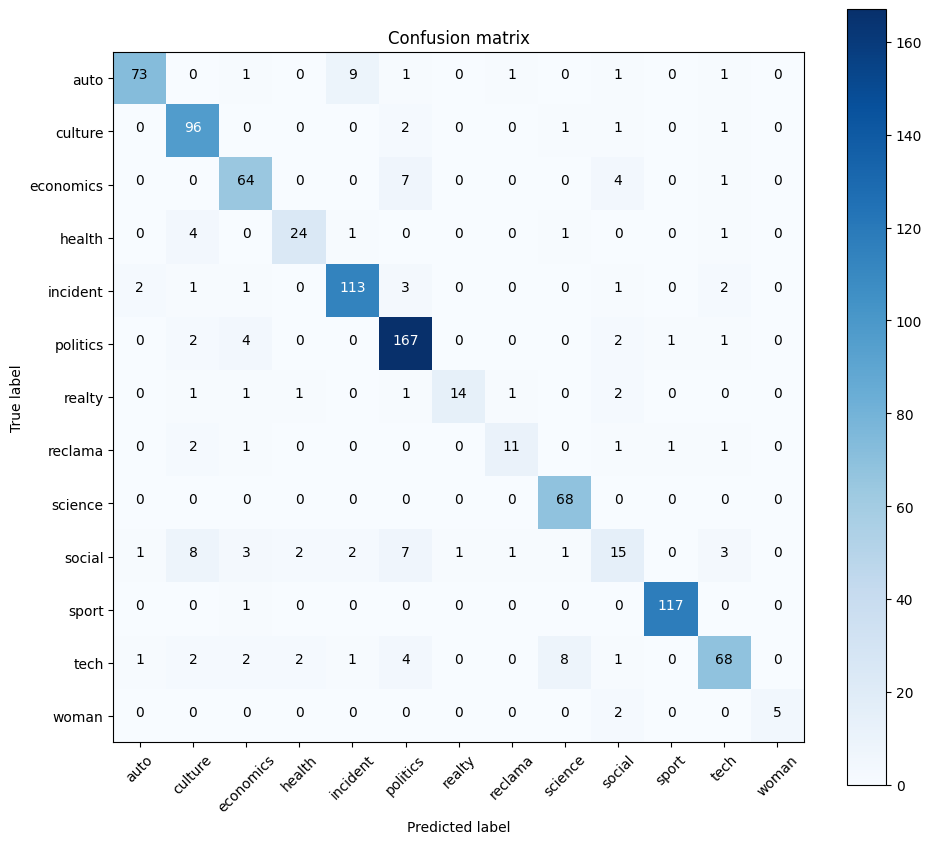

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

In [40]:
data['predict'] = pd.Series( clf.predict(data_tf) ).map( { labels[k]:k for k in labels } )

In [75]:
data

,text,tag,predict
0,"В Саудовской Аравии сняли первый антитеррористический мультфильм -\nтрехминутную ленту ""Внимание!"". ""Внимание!"" отражает точку зрения мирового\nсообщества на войну, развязанную терроризмом, и поэт...",politics,culture
1,"Вчера вечером в Японии состоялась премьера голливудского фильма о гейшах,\nвызвавшая негодование в связи с тем, что эти девушки представлены\nпроститутками, а играющие их актрисы - китаянки. Мало ...",culture,culture
2,"Российский кинорежиссер и генеральный директор киноконцерна ""Мосфильм""\nКарен Шахназаров награжден ""Золотой пирамидой"" на XXIX Каирском кинофестивале\nза выдающийся вклад в мировое киноискусство. ...",culture,culture
3,30 ноября выдающейся российской балерине Майе Плисецкой будет вручена\nмедаль имени княгини Барборы Радвилайте. Церемония награждения состоится\nв Вильнюсе в Литовском национальном театре оперы и ...,culture,culture
4,"Гарольд Пинтер не приедет за Нобелевской премией из-за болезниАнглийский\nдраматург Гарольд Пинтер, получивший Нобелевскую премию по литературе в\n2005 году, отправит в Стокгольм видеозапись своей...",culture,culture
...,...,...,...
3191,Православие.Ру В сентябре 2010 года Святейший Патриарх Кирилл посетит Камчатку\nВопросы подготовки к поездке Предстоятеля Русской Православной Церкви на\nКамчатку обсуждались на встрече Святейшего...,social,social
3192,Интерфакс Религия (interfax-religion.ru) В Минрегионразвития призывают\nроссиян не бояться своего духовного наследия подобно Европе В министерстве\nрегионального развития РФ считают крайне важным ...,social,culture
3193,"Окно возможностей В Эвенкинском муниципальном районе приступили к\nисследованию традиционного уклада жизни. В Эвенкию прибыла экспедиция под\nруководством профессора, заведующего кафедрой менеджме...",science,science
3194,"ИТАР-ТАСС. Новости из властных структур. Совет Федерации предлагает определить\nособенности традиционной охоты коренных народов Севера, Сибири и Дальнего\nВостока Совет Федерации внес на рассмотр...",politics,politics


In [ ]:
# Введение в анализ текстовой информации с помощью Python и методов машинного обучения
# https://habr.com/ru/post/205360/